In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import os

output_dir = "/content/drive/MyDrive/ML_Project/Output"
os.makedirs(output_dir, exist_ok=True)

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from matplotlib.animation import FuncAnimation, FFMpegWriter
import imageio.v2 as imageio

np.random.seed(42)
tf.random.set_seed(42)

This cell is the foundation of the entire analysis. We load the scikit-learn built-in **Digits dataset**, which consists of 1797 handwritten $8 \times 8$ images. Since different machine learning models (clustering, kNN, CNN) require the data in different formats and scales, we perform four critical steps:

1. **Flattening:** Each $8 \times 8$ image is flattened into a single feature vector of 64 pixels (for kNN, KMeans, GMM).
2. **Min-Max Scaling:** The pixel values (originally 0-16) are scaled to the [0, 1] range (X_images). This is ideal for neural networks (CNNs).
3. **Standardization:** The 64-pixel features are scaled to have a mean of 0 and a standard deviation of 1 (X_scaled). This equalizes feature importance and is necessary for distance-based algorithms like kNN, K-Means, and GMM.
4. **Splitting and Reshaping:**
*   The data is split into training (80%) and testing (20%) sets.
*   For the CNN, the data is reshaped back to a $8 \times 8 \times 1$ image structure (X_cnn), and the target labels are converted to one-hot encoded vectors (y_train_cat, y_test_cat).

These different preparations ensure each model receives the optimal data format for its training process.


In [38]:
# Load and Preprocess Digits
digits = load_digits()
X = digits.data        # 1797 samples, 64 pixels
y = digits.target

Xdf = pd.DataFrame(X, columns=[f'pixel_{i}' for i in range(X.shape[1])])

X_images = X / 16.0    # scale pixel values to [0,1]

# Standard scaling for clustering / kNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split for supervised models
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# For CNN: reshape images to 8x8x1
X_cnn = X_images.reshape(-1, 8, 8, 1)
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_cnn, y, test_size=0.2, random_state=42
)
y_train_cat = to_categorical(y_train_cnn, num_classes=10)
y_test_cat = to_categorical(y_test_cnn, num_classes=10)

# --- First 5 rows of raw pixel data ---
print("X (raw data) first 5 rows:")
print(X[:5])

print("\nXdf (DataFrame) first 5 rows:")
print(Xdf.head())

print("\nX_images (scaled 0-1) first 5 rows:")
print(X_images[:5])

print("\nX_scaled (standardized) first 5 rows:")
print(X_scaled[:5])

print("\nX_train first 5 rows:")
print(X_train[:5])

print("\nX_test first 5 rows:")
print(X_test[:5])

print("\ny_train first 5 labels:")
print(y_train[:5])

print("\ny_test first 5 labels:")
print(y_test[:5])

print("\nX_train_cnn first 5 images:")
print(X_train_cnn[:5])

print("\nX_test_cnn first 5 images:")
print(X_test_cnn[:5])

print("\ny_train_cat first 5 one-hot labels:")
print(y_train_cat[:5])

print("\ny_test_cat first 5 one-hot labels:")
print(y_test_cat[:5])


X (raw data) first 5 rows:
[[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
  15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
   0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
   0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
 [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
   3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
  16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
   0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
 [ 0.  0.  0.  4. 15. 12.  0.  0.  0.  0.  3. 16. 15. 14.  0.  0.  0.  0.
   8. 13.  8. 16.  0.  0.  0.  0.  1.  6. 15. 11.  0.  0.  0.  1.  8. 13.
  15.  1.  0.  0.  0.  9. 16. 16.  5.  0.  0.  0.  0.  3. 13. 16. 16. 11.
   5.  0.  0.  0.  0.  3. 11. 16.  9.  0.]
 [ 0.  0.  7. 15. 13.  1.  0.  0.  0.  8. 13.  6. 15.  4.  0.  0.  0.  2.
   1. 13. 13.  0.  0.  0.  0.  0.  2. 15. 11.  1.  0.  0.  0.  0.  0.  1.
  12. 12.  1.  0.  0.  0.  0. 

In [39]:
# Initialize Models

# Clustering
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42, warm_start=True)

# Supervised
knn = KNeighborsClassifier(n_neighbors=5)

# CNN
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(8,8,1)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
cnn.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Training Supervised Models**

This cell trains the two supervised classification models: k-Nearest Neighbors (kNN) and the Convolutional Neural Network (CNN).

* **kNN:** We train the model using the standardized data (X_train, y_train). Since kNN is a simple instance-based learner, training is fast (just storing the data). Its performance is immediately evaluated on the test set.

* **CNN:** We train the CNN model for 15 epochs using the reshaped, scaled image data (X_train_cnn, y_train_cat). A portion of the training data (validation_split=0.1) is set aside to monitor performance during training. After training, the model is evaluated on the dedicated test set.

This step establishes the baseline classification performance against which the unsupervised models will be contrasted later.

In [40]:
# Train Supervised Models
# kNN
knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test)
print("kNN Test Accuracy:", accuracy_score(y_test, y_knn_pred))

# CNN
cnn.fit(X_train_cnn, y_train_cat, epochs=15, batch_size=32, validation_split=0.1, verbose=2)
cnn_eval = cnn.evaluate(X_test_cnn, y_test_cat, verbose=0)
print("CNN Test Accuracy:", cnn_eval[1])


kNN Test Accuracy: 0.975
Epoch 1/15
41/41 - 2s - 55ms/step - accuracy: 0.3442 - loss: 2.1228 - val_accuracy: 0.5278 - val_loss: 1.9008
Epoch 2/15
41/41 - 0s - 5ms/step - accuracy: 0.7641 - loss: 1.5090 - val_accuracy: 0.8681 - val_loss: 1.0974
Epoch 3/15
41/41 - 0s - 5ms/step - accuracy: 0.8832 - loss: 0.7801 - val_accuracy: 0.9167 - val_loss: 0.5785
Epoch 4/15
41/41 - 0s - 5ms/step - accuracy: 0.9165 - loss: 0.4376 - val_accuracy: 0.9097 - val_loss: 0.4127
Epoch 5/15
41/41 - 0s - 5ms/step - accuracy: 0.9343 - loss: 0.3071 - val_accuracy: 0.9375 - val_loss: 0.3420
Epoch 6/15
41/41 - 0s - 5ms/step - accuracy: 0.9520 - loss: 0.2406 - val_accuracy: 0.9375 - val_loss: 0.2959
Epoch 7/15
41/41 - 0s - 5ms/step - accuracy: 0.9575 - loss: 0.1988 - val_accuracy: 0.9375 - val_loss: 0.2638
Epoch 8/15
41/41 - 0s - 5ms/step - accuracy: 0.9606 - loss: 0.1704 - val_accuracy: 0.9375 - val_loss: 0.2420
Epoch 9/15
41/41 - 0s - 5ms/step - accuracy: 0.9637 - loss: 0.1495 - val_accuracy: 0.9444 - val_loss: 

**Comprehensive Model Evaluation**
This crucial cell performs the full evaluation for all models using their respective test data:

1. Unsupervised Evaluation (Clustering)
We assess K-Means and Gaussian Mixture Model (GMM) using intrinsic metrics that don't require true labels:

   * Silhouette Score (Sil): Measures how similar a point is to its own cluster compared to other clusters. Higher is better.

   * Davies-Bouldin Index (DB): Measures the average similarity ratio between clusters. Lower is better.

   * Calinski-Harabasz Index (CH): Measures the ratio of between-cluster variance to within-cluster variance. Higher is better.

   * AIC/BIC (GMM only): Information criteria used for model selection; lower is generally preferred.

2. Supervised Evaluation (kNN and CNN)
We assess kNN and CNN using extrinsic metrics that rely on the true labels:

   * Accuracy: The overall proportion of correct predictions.

   * Precision, Recall, and F1-score: More robust metrics providing insight into the balance of false positives/negatives, averaged across all 10 classes (macro average).

   * Confusion Matrix: A visual tool (heatmap) that shows where misclassifications occur, helping us see which digits the models confuse with others.

This combined evaluation provides a complete picture of performance for both labeled and unlabeled scenarios.

Clustering metrics:
    model  silhouette  db_index    ch_index            aic           bic  \
0  KMeans    0.139377  1.877019  113.204289            NaN           NaN   
1     GMM    0.117905  2.002885  102.577554 -150541.924192 -32703.823195   

   n_clusters  
0          10  
1          10  
kNN Test Metrics:
   Accuracy : 0.9750
   Precision: 0.9765
   Recall   : 0.9769
   F1-score : 0.9765


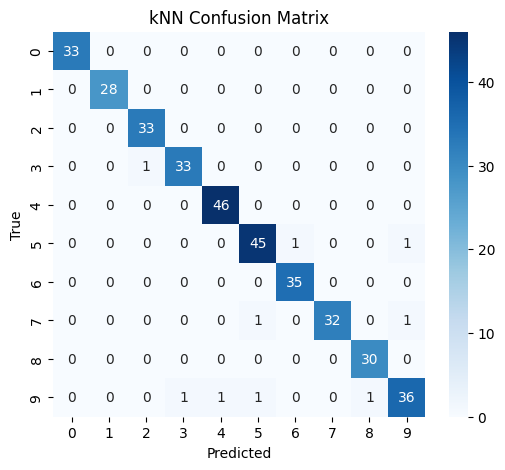

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
CNN Test Metrics:
   Accuracy : 0.9667
   Precision: 0.9724
   Recall   : 0.9671
   F1-score : 0.9685


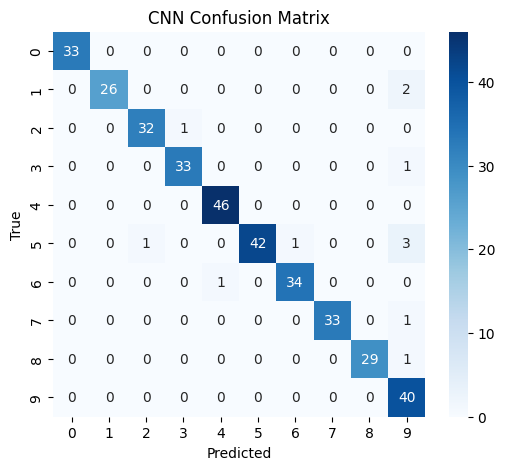

In [41]:
# --- Clustering Evaluation ---
clustering_models = {"KMeans": kmeans, "GMM": gmm}
clustering_results = []
for name, model in clustering_models.items():
    if isinstance(model, GaussianMixture):
        model.fit(X_scaled)
        labels = model.predict(X_scaled)
        aic = model.aic(X_scaled)
        bic = model.bic(X_scaled)
    else:
        labels = model.fit_predict(X_scaled)
        aic = bic = None

    valid = len(set(labels)) > 1 and not (set(labels) == {-1})
    sil = silhouette_score(X_scaled, labels) if valid else np.nan
    db = davies_bouldin_score(X_scaled, labels) if valid else np.nan
    ch = calinski_harabasz_score(X_scaled, labels) if valid else np.nan

    clustering_results.append({
        "model": name,
        "silhouette": sil,
        "db_index": db,
        "ch_index": ch,
        "aic": aic,
        "bic": bic,
        "n_clusters": len(set(labels)) - (1 if -1 in labels else 0)
    })

df_clustering = pd.DataFrame(clustering_results)
df_clustering.to_csv("/content/drive/MyDrive/ML_Project/Output/clustering_metrics.csv", index=False)
print("Clustering metrics:")
print(df_clustering)

# --- Supervised Evaluation ---
supervised_models = {"kNN": knn, "CNN": cnn}
supervised_results = []

for name, model in supervised_models.items():
    if name == "CNN":
        y_pred = np.argmax(model.predict(X_test_cnn), axis=1)
    else:
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    supervised_results.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    })

    print(f"{name} Test Metrics:")
    print(f"   Accuracy : {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall   : {rec:.4f}")
    print(f"   F1-score : {f1:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

df_supervised = pd.DataFrame(supervised_results)
df_supervised.to_csv("/content/drive/MyDrive/ML_Project/Output/supervised_metrics.csv", index=False)


**Analysis of Model Performance**

The evaluation results highlight a stark contrast between unsupervised clustering and supervised classification on the Digits dataset.

1. Unsupervised Clustering Performance
    *   Silhouette Score : K-Means 0.139, GMM 0.118, Finding: Scores close to 0 indicate poorly separated or overlapping clusters.
    *   Davies-Bouldin Index: K-Means 1.877, GMM 2.003, Finding: High scores confirm the clusters are not distinct or compact.

*Interpretation:* Both K-Means and GMM failed to find natural, well-defined groupings that correspond to the 10 digits. This confirms the data's complexity makes unsupervised separation ineffective.

2. Supervised Classification Performance: Both kNN and CNN achieved excellent performance, validating the quality of the standardized and image data, respectively.
    * kNN: Accuracy = 0.9750 	F1-Score = 0.9765, Finding: Slightly superior performance. kNN leverages the strength of the standardized 64-feature vector.

    * CNN: Accuracy = 0.9667, F1-Score = 0.9685, Finding: Excellent performance, demonstrating the CNN's ability to extract powerful spatial features from the raw $8 \times 8$ image structure.

**Confusion Matrix Insights**:
The Confusion Matrices (CMs) provide detail on the few errors made by these high-performing models:
* kNN CM: Shows a total of $\approx 9$ errors on the test set. The model struggled most with the digit 9, misclassifying it as a 3, 4, 5, and 8 once each. It also confused one 3 as a 2.

* CNN CM: Shows a total of $\approx 12$ errors.
   * It confused two 1s as 9s.
   * It misclassified one 2 as a 3, and one 5 as a 6.
   * The largest confusion is with the digit 5, where it misclassified three instances as 9s.

Overall:
While both models are nearly perfect, the kNN achieved a marginally higher accuracy. The errors, visible in the CMs, primarily occur when the models confuse digits that share similar shapes (e.g., confusing a written '9' with '3' or '5').





**Runtime Complexity Analysis**
This cell measures the empirical runtime complexity—how fast the models execute—as the size of the training data ($n$) increases. This is crucial for understanding the scalability of the algorithms.

* The code times the combined fit and predict steps across five different sample sizes.

* The results are plotted to visualize how execution time scales with $n$.

* Theoretical Complexity: K-Means and GMM have complexities related to $O(n \cdot i)$ (where $i$ is iterations), kNN is dominated by $O(n \cdot d \cdot \log k)$ during prediction, and CNN is $O(n \cdot w \cdot i)$ where $w$ is the number of weights.


⏱ Measuring runtime for sample size = 50
   KMeans     took 25.41 ms
   GMM        took 17.04 ms
   kNN        took 2.14 ms
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
   CNN        took 242.48 ms

⏱ Measuring runtime for sample size = 486
   KMeans     took 47.20 ms
   GMM        took 104.36 ms
   kNN        took 6.39 ms
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
   CNN        took 310.45 ms

⏱ Measuring runtime for sample size = 923
   KMeans     took 81.91 ms
   GMM        took 798.97 ms
   kNN        took 31.69 ms
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
   CNN        took 382.79 ms

⏱ Measuring runtime for sample size = 1360
   KMeans     took 98.94 ms
   GMM        took 659.28 ms
   kNN        took 51.01 ms
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
   CNN        took 390.26 ms

⏱ Measuring runtime for sample size = 1797
   KMeans     took 134.67 ms
   GMM        took 8108.34 ms
   kNN        took 86.90 ms
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
   CNN        took 422.56 ms


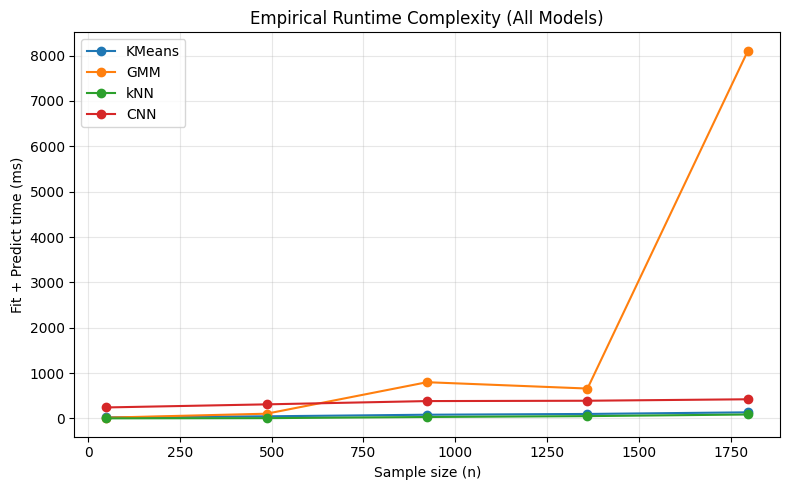

In [42]:
# complexity analysis
all_models = {
    "KMeans": kmeans,
    "GMM": gmm,
    "kNN": knn,
    "CNN": cnn
}

sample_sizes = np.linspace(50, len(X_scaled), num=5, dtype=int)
timings = {name: [] for name in all_models}

for n in sample_sizes:
    print(f"\n⏱ Measuring runtime for sample size = {n}")

    # Subset for clustering and kNN
    idx = np.random.choice(len(X_scaled), n, replace=False)
    Xs_scaled = X_scaled[idx]
    y_s = y[idx]

    # Subset for CNN (reshape to 8x8x1)
    Xs_cnn = X_images[idx].reshape(-1, 8, 8, 1)
    y_s_cat = to_categorical(y_s, num_classes=10)

    for name, model in all_models.items():
        start = time.time()

        if name in ["KMeans", "GMM"]:
            if hasattr(model, "fit_predict"):
                model.fit_predict(Xs_scaled)
            else:
                model.fit(Xs_scaled)
        elif name == "kNN":
            model.fit(Xs_scaled, y_s)
            _ = model.predict(Xs_scaled)
        elif name == "CNN":
            # Train for 1 epoch only to measure time
            model.fit(Xs_cnn, y_s_cat, epochs=1, batch_size=32, verbose=0)
            _ = model.predict(Xs_cnn)

        t_ms = (time.time() - start) * 1000
        timings[name].append(t_ms)
        print(f"   {name:<10} took {t_ms:.2f} ms")

# Plot runtime complexity
plt.figure(figsize=(8,5))
for name, times in timings.items():
    plt.plot(sample_sizes, times, '-o', label=name)
plt.xlabel("Sample size (n)")
plt.ylabel("Fit + Predict time (ms)")
plt.title("Empirical Runtime Complexity (All Models)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ML_Project/Output/runtime_complexity_all_models.png", dpi=200)
plt.show()

**Runtime Complexity Analysis**
The timing analysis measured the combined Fit + Predict time as the sample size ($n$) increased from 50 to 1797.

1. Most Efficient Models (Best Scalability)
    * kNN (k-Nearest Neighbors): Fastest model overall, consistently under $100\text{ ms}$ even for the full dataset ($86.90\text{ ms}$). Shows the most linear and predictable scaling, making it the most efficient algorithm tested here.
    
    * K-Means: Scales very well, with runtime increasing smoothly from $25.41\text{ ms}$ to $134.67\text{ ms}$. This confirms its efficiency for clustering on this dataset size.
    
2. Least Efficient Model (Worst Scalability)
    * GMM (Gaussian Mixture Model): Exhibits the worst scaling due to its high computational complexity ($O(n \cdot d^3)$). The runtime spikes dramatically, leaping from $104\text{ ms}$ (at $n=486$) to over $8$ seconds ($8108.34\text{ ms}$) at the full size. This lack of scalability makes GMM impractical for large datasets with high dimensionality ($d=64$).
    
3. Stable Model (High Constant Cost)
    * CNN (Convolutional Neural Network): Has the highest initial overhead ($242.48\text{ ms}$), but its runtime grows very slowly afterward (only reaching $422.56\text{ ms}$). This demonstrates a high but stable computational cost per epoch, scaling reasonably well with $n$.In conclusion: For maximum speed and scalability, kNN is superior. GMM is the clear bottleneck due to its steep complexity curve.

**In conclusion:** For maximum speed and scalability, kNN is superior. GMM is the clear bottleneck due to its steep complexity curve.

**Live Model Evolution**
This cell creates a short video to visually track model mechanisms for three sample digits across 10 training iterations.

The animation shows:

1. K-Means & GMM: How the cluster labels change as these unsupervised models refine their parameters over the first 10 steps. GMM output includes probability scores for the sample.

2. kNN & CNN: The final, correct supervised prediction (kNN and CNN) versus the True label.

This directly contrasts the evolving, often-incorrect unsupervised grouping with the static, highly accurate supervised classification for the same data points.

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


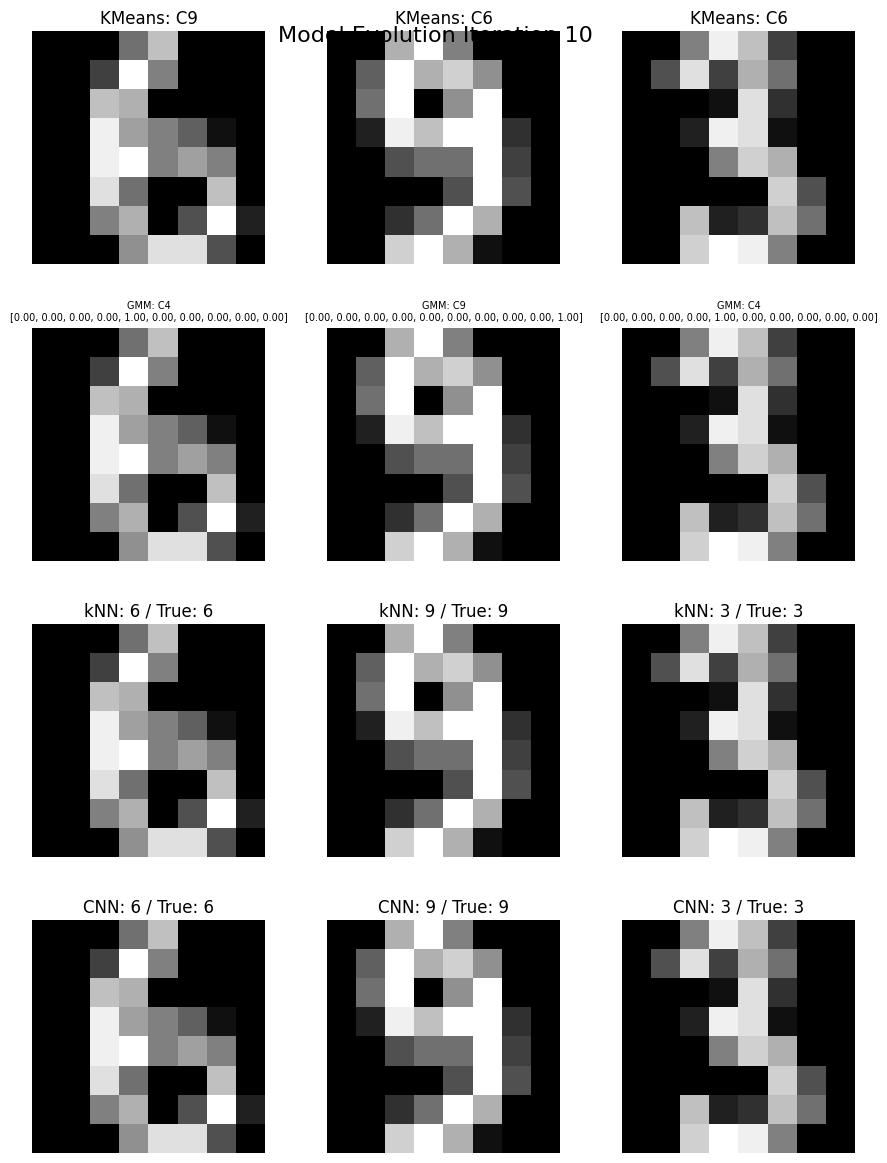

In [43]:
# Live Visualization
sample_images = 3
max_iter = 10
np.random.seed(42)
n_samples = X_scaled.shape[0]
sample_indices = np.random.choice(n_samples, sample_images, replace=False)

# Precompute CNN predictions
cnn_preds = np.argmax(cnn.predict(X_cnn), axis=1)

# PCA for cluster visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

# Setup figure
fig, axes = plt.subplots(4, sample_images, figsize=(3*sample_images, 12))
if sample_images == 1:
    axes = axes.reshape(4,1)

plt.tight_layout()

def update(frame):
    iter_num = frame + 1
    fig.suptitle(f"Model Evolution Iteration {iter_num}", fontsize=16)

    # --- KMeans ---
    kmeans.set_params(max_iter=iter_num)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    for i, idx in enumerate(sample_indices):
        axes[0,i].clear()
        axes[0,i].imshow(X_images[idx].reshape(8,8), cmap="gray")
        axes[0,i].axis('off')
        axes[0,i].set_title(f"KMeans: C{kmeans_labels[idx]}")

    # --- GMM ---
    gmm.set_params(max_iter=iter_num)
    gmm.fit(X_scaled)
    gmm_labels = gmm.predict(X_scaled)
    gmm_probs = gmm.predict_proba(X_scaled)
    for i, idx in enumerate(sample_indices):
        axes[1,i].clear()
        axes[1,i].imshow(X_images[idx].reshape(8,8), cmap="gray")
        axes[1,i].axis('off')
        axes[1,i].set_title(f"GMM: C{gmm_labels[idx]}\n[{', '.join([f'{p:.2f}' for p in gmm_probs[idx]])}]", fontsize=7)

    # --- kNN ---
    knn_preds = knn.predict(X_scaled)
    for i, idx in enumerate(sample_indices):
        axes[2,i].clear()
        axes[2,i].imshow(X_images[idx].reshape(8,8), cmap="gray")
        axes[2,i].axis('off')
        axes[2,i].set_title(f"kNN: {knn_preds[idx]} / True: {y[idx]}")

    # --- CNN ---
    for i, idx in enumerate(sample_indices):
        axes[3,i].clear()
        axes[3,i].imshow(X_images[idx].reshape(8,8), cmap="gray")
        axes[3,i].axis('off')
        axes[3,i].set_title(f"CNN: {cnn_preds[idx]} / True: {y[idx]}")

anim = FuncAnimation(fig, update, frames=max_iter, repeat=False)

# Record video
writer = FFMpegWriter(fps=2, metadata=dict(artist='ML Demo'), bitrate=1800)
anim.save("/content/drive/MyDrive/ML_Project/Output/digits_evolution.mp4", writer=writer)

plt.show()


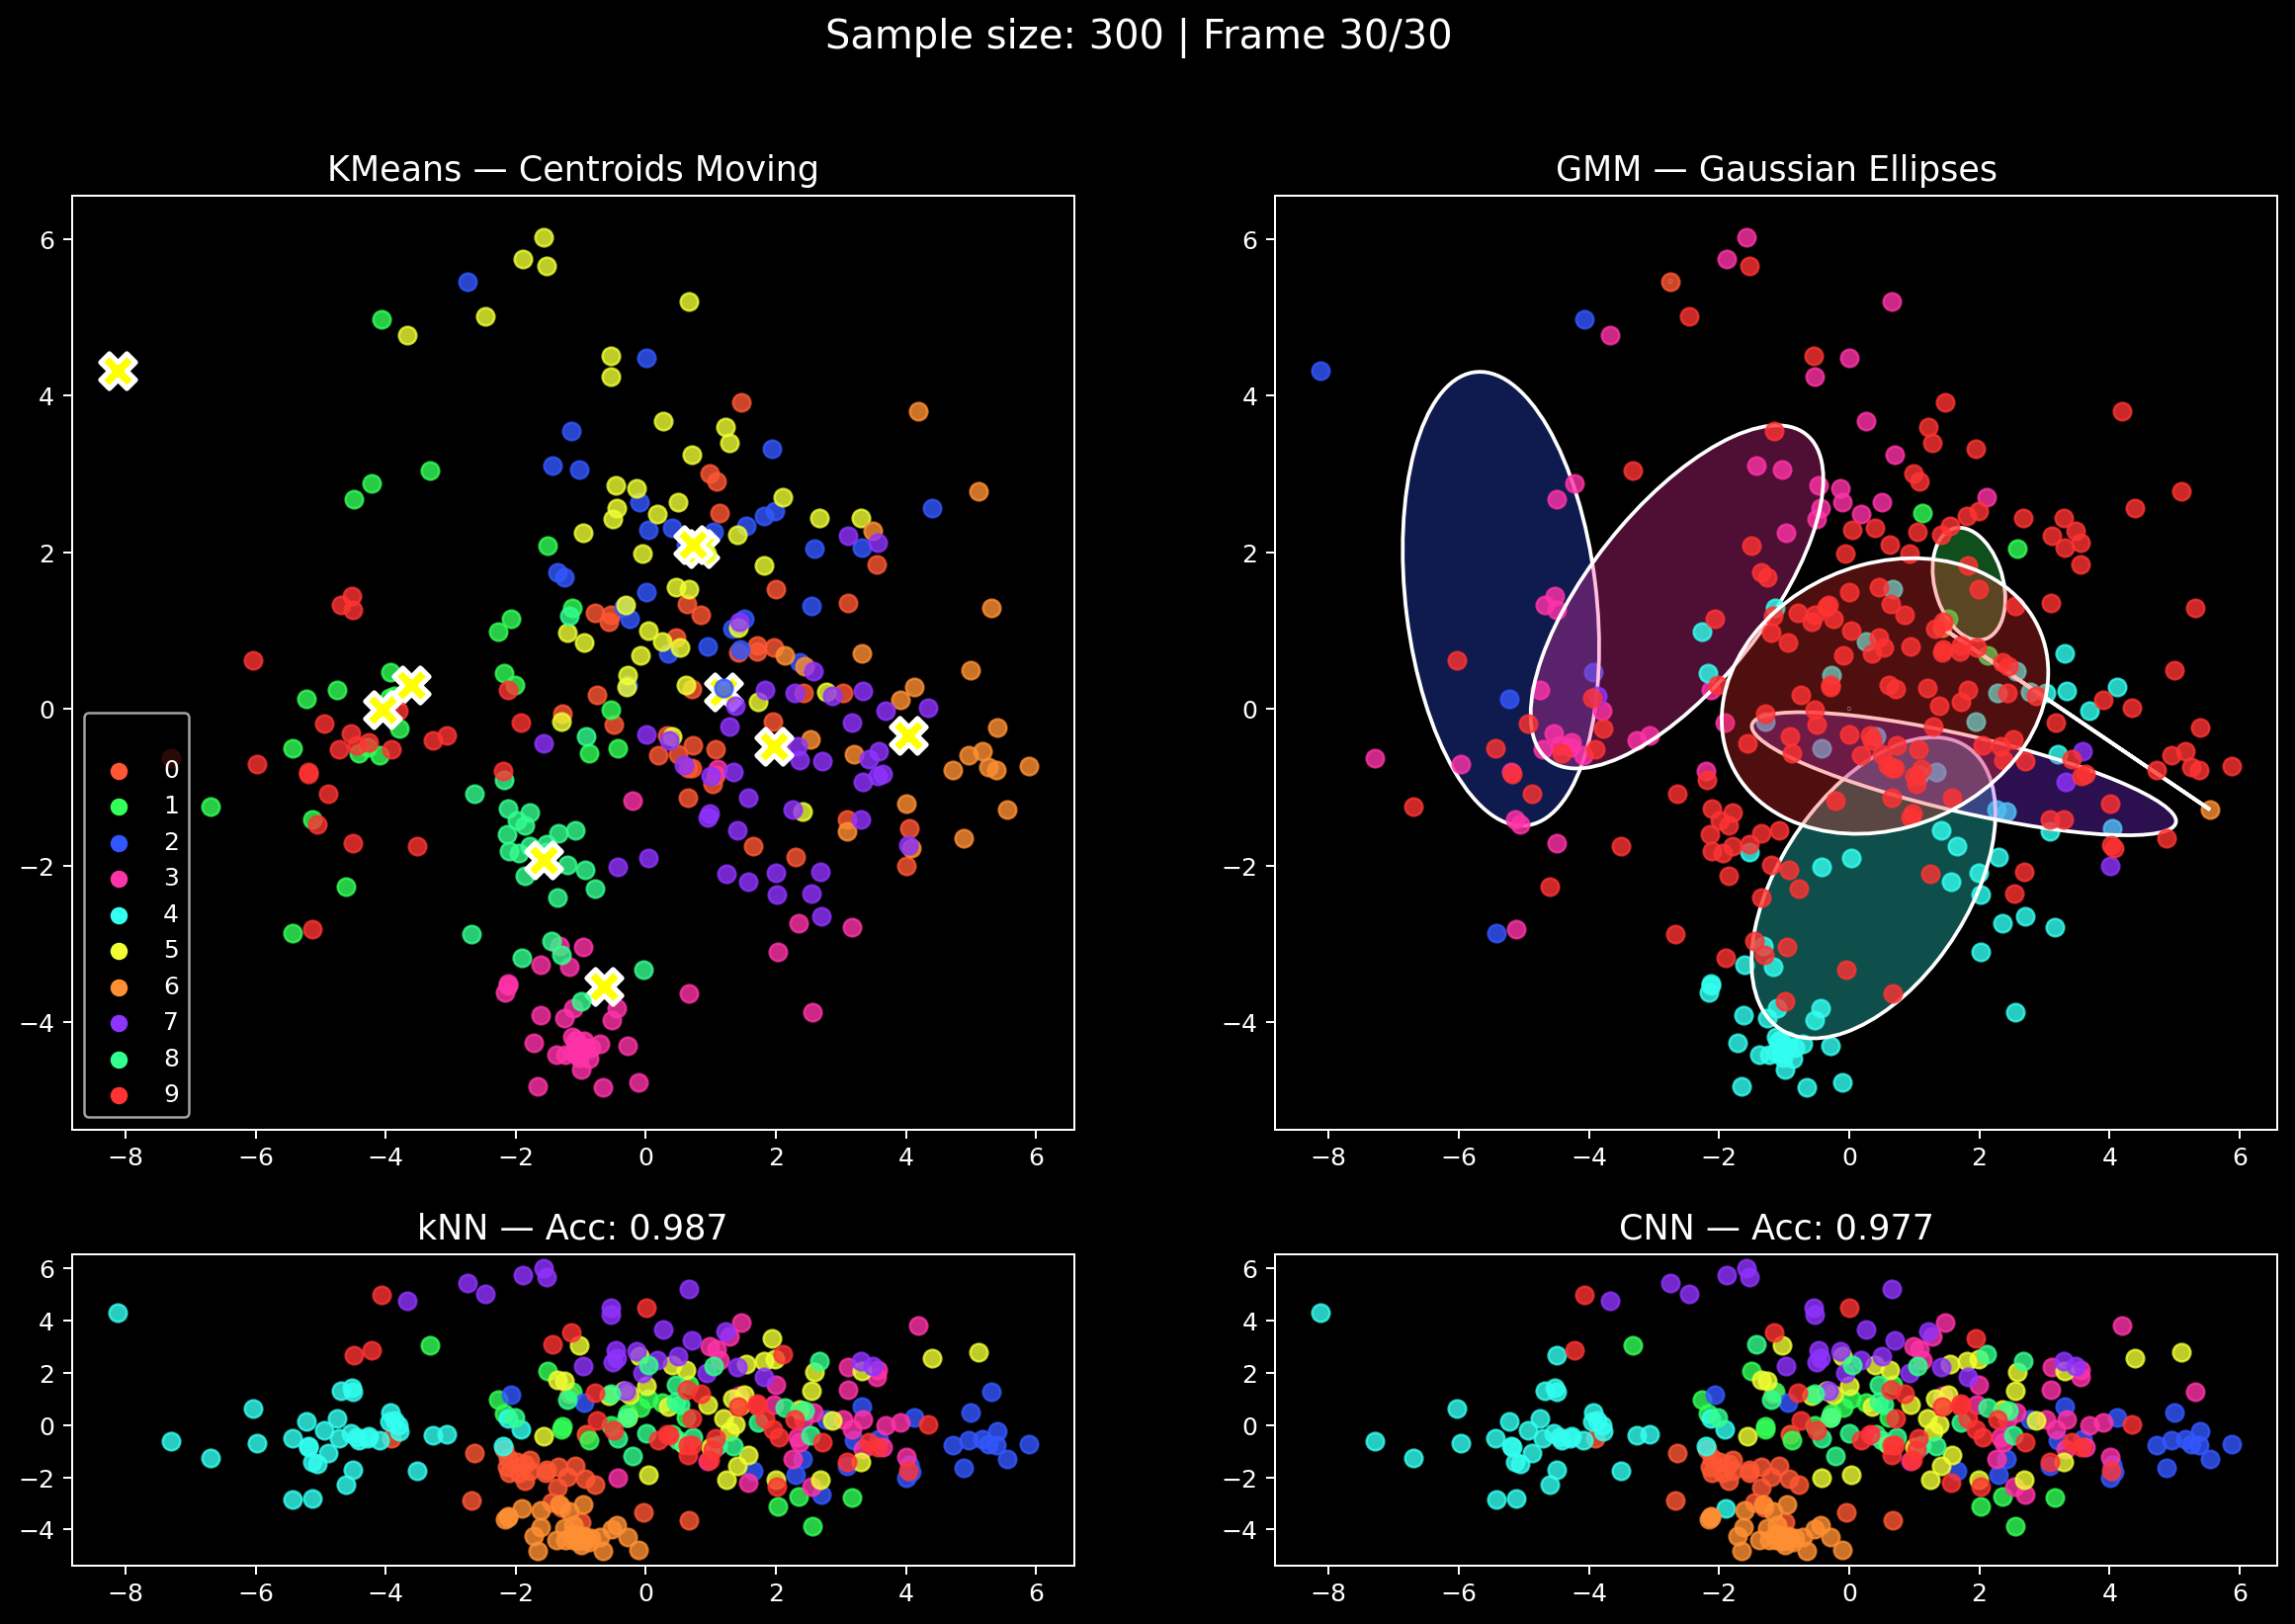

/tmp/ipython-input-3153673235.py:149: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = [imageio.imread(f) for f in filenames]


🎬 Advanced animation saved: /content/drive/MyDrive/ML_Project/Output/digits_advanced_animation.mp4


In [47]:
# PARAMETERS - MODIFIED
n_samples_viz = 300          # number of points in visualization (set to 300)
max_iter = 30                # number of frames / iterations (set to 30)
fps = 2
output_path = "/content/drive/MyDrive/ML_Project/Output/digits_advanced_animation.mp4"

# PREPARE DATA
y_true = np.array(y).ravel()  # 1D labels

# PCA for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

np.random.seed(42)
sample_idx = np.random.choice(len(X_scaled), n_samples_viz, replace=False)

X_samples = X_2d[sample_idx]
X_scaled_samples = X_scaled[sample_idx]
y_samples = y_true[sample_idx]
X_images_samples = X_images[sample_idx].reshape(-1, 8, 8, 1)

colors = ['#FF5733','#33FF57','#3357FF','#FF33A8','#33FFF0',
          '#F0FF33','#FF8F33','#8F33FF','#33FF8F','#FF3333']

# ANIMATION SETUP
fig = plt.figure(figsize=(16, 10), dpi=180)
fig.patch.set_facecolor('black')
filenames = []

# Initialize previous centroids for KMeans
prev_centroids = None

for iter_num in range(1, max_iter + 1):
    plt.clf()
    gs = fig.add_gridspec(2, 2, height_ratios=[3, 1])

    ax_km   = fig.add_subplot(gs[0, 0])
    ax_gmm  = fig.add_subplot(gs[0, 1])
    ax_knn  = fig.add_subplot(gs[1, 0])
    ax_cnn  = fig.add_subplot(gs[1, 1])

    for ax in [ax_km, ax_gmm, ax_knn, ax_cnn]:
        ax.set_facecolor('black')
        ax.tick_params(colors='white')
        for spine in ax.spines.values():
            spine.set_color('white')

    fig.suptitle(f"Sample size: {n_samples_viz} | Frame {iter_num}/{max_iter}", color='white', fontsize=16)

    # KMeans
    kmeans.set_params(max_iter=1)  # update 1 iteration at a time
    if prev_centroids is None:
        # Initialize prev_centroids in the first iteration
        km_labels = kmeans.fit_predict(X_scaled_samples)
        centroids = kmeans.cluster_centers_
        prev_centroids = pca.transform(centroids) # Transform initial centroids for 2D plot
    else:
        # Subsequent iterations: fit and get new labels/centroids
        km_labels = kmeans.fit_predict(X_scaled_samples)
        centroids = kmeans.cluster_centers_

    centroids_2d = pca.transform(centroids)

    ax_km.set_title("KMeans — Centroids Moving", color='white', fontsize=14)
    for i in range(10):
        pts = X_samples[km_labels == i]
        ax_km.scatter(pts[:,0], pts[:,1], s=50, color=colors[i], alpha=0.8)
        # Plot centroid
        ax_km.scatter(centroids_2d[i,0], centroids_2d[i,1], s=200, marker='X', color='yellow', edgecolor='white', lw=2)
        # Draw line from previous centroid
        ax_km.plot([prev_centroids[i,0], centroids_2d[i,0]], [prev_centroids[i,1], centroids_2d[i,1]], 'w--', lw=1)
    prev_centroids = centroids_2d.copy()

    # Add legend
    for i in range(10):
        ax_km.scatter([], [], color=colors[i], label=str(i))
    ax_km.legend(title='Digit', facecolor='black', framealpha=0.8, labelcolor='white')

    # GMM
    gmm.set_params(max_iter=iter_num)
    gmm.fit(X_scaled_samples)
    gmm_labels = gmm.predict(X_scaled_samples)
    gmm_means_2d = pca.transform(gmm.means_)
    gmm_covs_2d = [pca.components_ @ cov @ pca.components_.T for cov in gmm.covariances_]

    ax_gmm.set_title("GMM — Gaussian Ellipses", color='white', fontsize=14)
    for i in range(gmm.n_components):
        pts = X_samples[gmm_labels == i]
        ax_gmm.scatter(pts[:,0], pts[:,1], s=50, color=colors[i % 10], alpha=0.8)

        # Draw ellipses
        cov = gmm_covs_2d[i]
        # Ensure cov is positive semi-definite (for robust SVD)
        cov = (cov + cov.T) / 2.0
        U, s_vals, _ = np.linalg.svd(cov)
        s_vals = np.maximum(s_vals, 1e-6) # prevent issues with near-zero variance
        width, height = 2 * np.sqrt(s_vals[:2])
        angle = np.degrees(np.arctan2(U[1,0], U[0,0]))
        ell = Ellipse(
            xy=gmm_means_2d[i],
            width=width, height=height,
            angle=angle,
            facecolor=colors[i % 10]+'50',  # semi-transparent
            edgecolor='white',
            lw=1.5
        )
        ax_gmm.add_patch(ell)

    # kNN
    y_pred_knn = knn.predict(X_scaled_samples)
    acc_knn = accuracy_score(y_samples, y_pred_knn)

    ax_knn.set_title(f"kNN — Acc: {acc_knn:.3f}", color='white', fontsize=14)
    for i in range(10):
        pts = X_samples[y_pred_knn == i]
        ax_knn.scatter(pts[:,0], pts[:,1], s=50, color=colors[i], alpha=0.8)

    # CNN
    y_pred_cnn = np.argmax(cnn.predict(X_images_samples, verbose=0), axis=1)
    acc_cnn = accuracy_score(y_samples, y_pred_cnn)

    ax_cnn.set_title(f"CNN — Acc: {acc_cnn:.3f}", color='white', fontsize=14)
    for i in range(10):
        pts = X_samples[y_pred_cnn == i]
        ax_cnn.scatter(pts[:,0], pts[:,1], s=50, color=colors[i], alpha=0.8)

    # saving
    fname = f"/tmp/frame_{iter_num}.png"
    plt.savefig(fname, dpi=220, bbox_inches="tight", facecolor='black')
    filenames.append(fname)

    clear_output(wait=True)
    display(fig)

plt.close()

frames = [imageio.imread(f) for f in filenames]
imageio.mimsave(output_path, frames, fps=fps)
print("Advanced animation saved:", output_path)

**Interpretation: Unsupervised vs. Supervised Models on Digits**

The results show a stark contrast between unsupervised clustering (K-Means/GMM) and supervised classification (kNN/CNN) on the Digits dataset.
1. Unsupervised Clustering Fails (Top Plots)
Unsupervised models show poor performance, as evidenced by the metrics and the top plots:
* Silhouette Score ($\approx 0.14$): This value, close to zero, indicates Poor Separation. Clusters are not distinct.
* Davies-Bouldin Index ($\approx 1.9$): This high value indicates High Overlap and poor cluster spacing.
* Visualization Evidence: The 2D PCA plots (K-Means and GMM) show heavy overlap among points, regardless of the assigned cluster. The data lacks the simple, compact, or spherical structure needed for effective clustering in this projected space.


**Conclusion:** The high overlap in the 2D visualization confirms that the intrinsic structure of the 64-dimensional data is too complex for simple clustering algorithms to separate without label information.

2. Supervised Classification Excels (Bottom Plots)

* Accuracy ($\approx 0.975$): Achieves Near-perfect classification.
* F1-Score ($\approx 0.976$): Shows High Precision and Recall across all digit classes.
* Visualization Link: The high accuracy proves that despite the visual overlap in 2D, the digit classes are well-separated in the original (or learned) high-dimensional feature space. The models successfully find complex, non-linear boundaries that distinguish the digits.

**Conclusion:** Supervised models leverage the provided labels to find highly effective decision boundaries in the high-dimensional space, easily overcoming the structural challenges that defeat unsupervised clustering.